In [11]:
# libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import seaborn as sns

from tqdm import tqdm
import random

import torch
import torch.nn as nn
import clip

import config


## 1 - Dataset and Selection of a Small Subset for Few-Shot Learning

### Selecting a Small Subset
For fine-tuning, we will use a small, balanced subset of the EuroSAT dataset. Instead of using the full dataset, we will randomly sample 10 images per class to simulate a **few-shot learning** scenario. The goal is to test whether training on a small number of images can improve classification performance.



In [14]:
classes = config.CLASSES
print("Classes found: ", classes)

modified_classes = [config.CLASSNAME_DICT[c] for c in classes]
print("Modified classes: ", modified_classes)


Classes found:  ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Modified classes:  ['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial', 'Pasture', 'Permanent Crop', 'Residential', 'River', 'Sea or Lake']


In [15]:
def get_class_indices(class_list, class_names):
    """ Convert class names to numerical labels. """
    return torch.tensor([class_names.index(cls) for cls in class_list], dtype=torch.long)

In [16]:
device = (
    torch.device("mps") if torch.backends.mps.is_available() else
    torch.device("cuda") if torch.cuda.is_available() else
    torch.device("cpu")
)
print("Device: ", device)

Device:  mps


In [17]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

clip_model.to(device)

for param in clip_model.parameters():
    param.requires_grad = False

print("CLIP model loaded and backbone frozen.")

CLIP model loaded and backbone frozen.


In [18]:
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.text_model
        self.encoder = clip_model.text_model.encoder
        self.positional_embedding = clip_model.text_model.embeddings.position_embedding
        self.ln_final = clip_model.text_model.final_layer_norm
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self, prompts):
        seq_length = prompts.size(1)  # Sequence length (number of tokens)
        positions = torch.arange(seq_length, device=prompts.device).unsqueeze(0)  # Shape [1, seq_length]
        
        # Get the positional embeddings for each position
        pos_embeddings = self.positional_embedding(positions)  # Shape [1, seq_length, embedding_dim]
        
        x = prompts + pos_embeddings
        x = x.reshape(x.size(0), x.size(1), -1)  # NLD -> LND
        encoder_outputs = self.encoder(x)

        last_hidden_state = encoder_outputs[0]
        pooled_output = last_hidden_state[:, 0, :]
        pooled_output = self.ln_final(pooled_output)

        text_features = self.text_projection(pooled_output)

        return text_features


In [19]:
class SimplePromptLearner(nn.Module):
    def __init__(self, clip_model, classnames, n_ctx=8, ctx_init=None):
        super().__init__()

        self.n_cls = len(classnames)
        self.n_ctx = n_ctx
        self.ctx_dim = clip_model.text_model.final_layer_norm.weight.shape[0]
        dtype = clip_model.dtype

        # Initialize context vectors
        if ctx_init:
            # Initialize with provided context string
            ctx_init = ctx_init.replace("_", " ")
            n_ctx = len(ctx_init.split(" "))
            prompt = clip.tokenize(ctx_init)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt).type(dtype)
            ctx_vectors = embedding[0, 1 : 1 + n_ctx, :]
            prompt_prefix = ctx_init
        else:
            print("Initializing class-specific contexts")
            ctx_vectors = torch.empty(self.n_cls, n_ctx, self.ctx_dim, dtype=dtype).to(device)
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)

        print(f'Initial context: "{prompt_prefix}"')
        print(f"Number of context words (tokens): {n_ctx}")

        self.ctx = nn.Parameter(ctx_vectors, requires_grad=True).to(device)  # to be optimized

        # Prepare the prompts
        classnames = [name.replace("_", " ") for name in classnames]
        prompts = [prompt_prefix + " " + name + "." for name in classnames]

        # Tokenize and get embeddings for class names
        tokenized_prompts = tokenizer(prompts, padding=True, return_tensors="pt", truncation=True, max_length=77).to(device)
        
        with torch.no_grad():
            input_ids = tokenized_prompts["input_ids"]
            embedding = clip_model.text_model.embeddings.token_embedding(input_ids).type(dtype)

        # Store prefix and suffix
        self.register_buffer("token_prefix", embedding[:, :1, :])  # Start of sequence token
        self.register_buffer("token_suffix", embedding[:, 1+n_ctx:, :])  # Class names and rest

        self.tokenized_prompts = tokenized_prompts

    def forward(self):
        # The context vectors
        ctx = self.ctx

        # Concatenate the prefix, context, and suffix
        prompts = torch.cat([self.token_prefix, ctx, self.token_suffix], dim=1)

        return prompts



In [20]:
import gc
torch.cuda.empty_cache()
gc.collect()


8

In [25]:
validation_df = pd.read_csv("validation_data/validation_set.csv")

validation_labels = get_class_indices(validation_df["Class"].tolist(), classes).to(device)

validation_images = [Image.open(img_path).convert("RGB") for img_path in validation_df["Image Path"].tolist()]
validation_inputs = clip_processor(images=validation_images, return_tensors="pt", padding=True).to(device)

In [27]:
num_epochs=500

losses = {}
validation_losses = {}
validation_accuracies = {}

for few_shot in [1,2,4,8,16]:
    few_shot_df = pd.read_csv(f"few_shot_data/few_shot_{few_shot}.csv")
    few_shot_images = [Image.open(img_path).convert("RGB") for img_path in few_shot_df["Image Path"].tolist()]
    inputs = clip_processor(images=few_shot_images, return_tensors="pt", padding=True).to(device)

    labels = get_class_indices(few_shot_df["Class"].tolist(), classes)
    labels = labels.to(device)

    prompt_learner = SimplePromptLearner(clip_model, modified_classes, n_ctx=16, ctx_init=None).to(device)
    text_encoder = TextEncoder(clip_model=clip_model).to(device)

    optimizer = optim.Adam(prompt_learner.parameters(), lr=0.01)

    criterion = nn.CrossEntropyLoss()

    losses[few_shot] = []
    validation_losses[few_shot] = []
    validation_accuracies[few_shot] = []


    for epoch in range(num_epochs+1):
        optimizer.zero_grad()
        
        prompts = prompt_learner()
        
        # Get updated text features using learned prompts, and image features
        text_features = text_encoder(prompts)
        image_features = clip_model.get_image_features(**inputs)

        # Normalize features
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Compute cosine similarity
        logit_scale = clip_model.logit_scale.exp()
        logits = image_features @ text_features.T
        logits *= logit_scale
        
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        losses[few_shot].append(loss.item())

        if epoch % 50 == 0:
            with torch.no_grad():
                prompts = prompt_learner()

                text_features = text_encoder(prompts)
                image_features = clip_model.get_image_features(**validation_inputs)

                # Normalize features
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)
                image_features = image_features / image_features.norm(dim=-1, keepdim=True)

                # Compute cosine similarity
                logit_scale = clip_model.logit_scale.exp()
                val_logits = image_features @ text_features.T
                val_logits *= logit_scale

                val_loss = criterion(val_logits, validation_labels)
                
                predictions = torch.argmax(val_logits, dim=1)
            
            accuracy = (predictions == validation_labels).float().mean().item()
            
            validation_accuracies[few_shot].append(accuracy)
            validation_losses[few_shot].append((epoch, val_loss.item()))
            
            if epoch % 100 == 0:    
                print(f"{few_shot}-shot Epoch [{epoch}/{num_epochs}]:") 
                print(f"\tTraining Loss: {loss.item():.4f}")
                print(f"\tValidation Loss: {val_loss.item():.4f}")
                print(f"\tValidation Accuracy: {accuracy * 100:.2f}%\n")

Initializing class-specific contexts
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
1-shot Epoch [0/500]:
	Training Loss: 3.8234
	Validation Loss: 4.2250
	Validation Accuracy: 12.80%

1-shot Epoch [100/500]:
	Training Loss: 0.0003
	Validation Loss: 1.6599
	Validation Accuracy: 53.20%

1-shot Epoch [200/500]:
	Training Loss: 0.0002
	Validation Loss: 1.6436
	Validation Accuracy: 54.20%

1-shot Epoch [300/500]:
	Training Loss: 0.0001
	Validation Loss: 1.6380
	Validation Accuracy: 54.40%

1-shot Epoch [400/500]:
	Training Loss: 0.0001
	Validation Loss: 1.6376
	Validation Accuracy: 54.20%

1-shot Epoch [500/500]:
	Training Loss: 0.0001
	Validation Loss: 1.6400
	Validation Accuracy: 54.60%

Initializing class-specific contexts
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
2-shot Epoch [0/500]:
	Training Loss: 3.6086
	Validation Loss: 3.7289
	Validation Accuracy: 20.00%

2-shot Epoch [100/500]:
	Training Loss: 

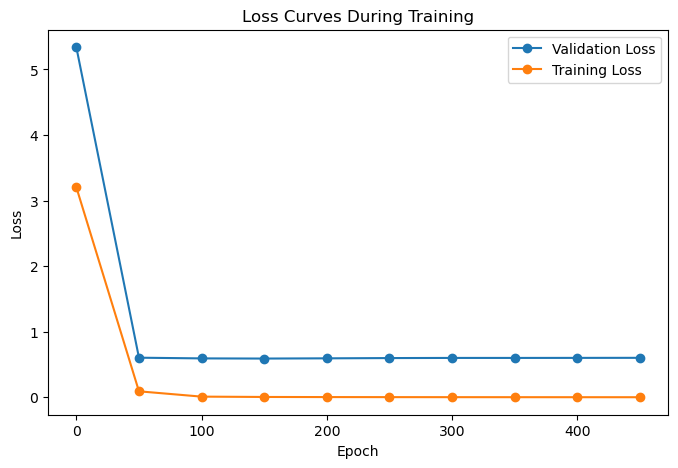

In [597]:
plt.figure(figsize=(8, 5))
# Extract epochs and losses for validation
epochs, val_losses = zip(*validation_losses)
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.plot(epochs, losses, label="Training Loss", marker='o')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves During Training")
plt.legend()
plt.show()


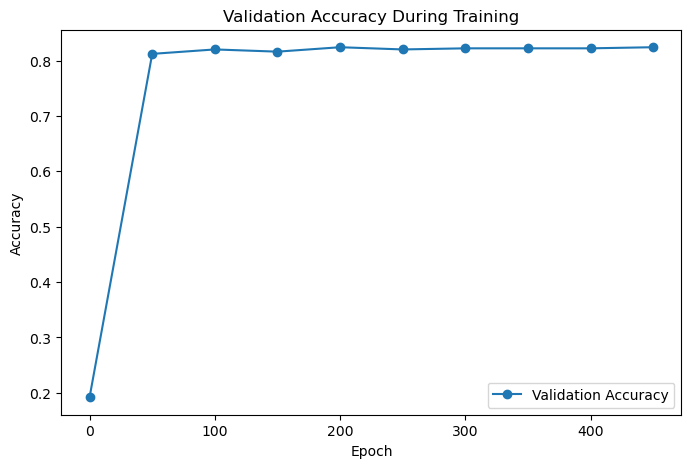

In [598]:
plt.figure(figsize=(8, 5))
# Extract epochs and losses for validation
epochs, val_losses = zip(*validation_losses)
plt.plot(epochs, validation_accuracies, label="Validation Accuracy", marker='o')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy During Training")
plt.legend()
plt.show()
